In [1]:
import torch
import pandas as pd
import requests

from io import StringIO

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
base_url = "https://raw.githubusercontent.com/Venkat2811/Analyzing-Book-Data-Hadoop/master/2%20Raw%20Input%20Files/"
filenames = ["BX-Book-Ratings.csv", "BX-Books.csv", "BX-Users.csv"]

dataframes = {}

for filename in filenames:
    # Construct the full URL
    url = base_url + filename
    
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    
    # Read the CSV content into a DataFrame
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)  # Adjust the separator if needed
    dataframes[filename] = df

users = dataframes["BX-Users.csv"]
books = dataframes["BX-Books.csv"]
ratings = dataframes["BX-Book-Ratings.csv"]

In [3]:
# Display the first few rows of each dataset
print(books.info())
# display a horizontal line to separate the outputs
print('-'*100)
print(users.info())
print('-'*100)
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location

In [4]:
# Display the first few rows of each dataset
print(books.head())
# display a horizontal line to separate the outputs
print('-'*100)
print(users.head())
print('-'*100)
print(ratings.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

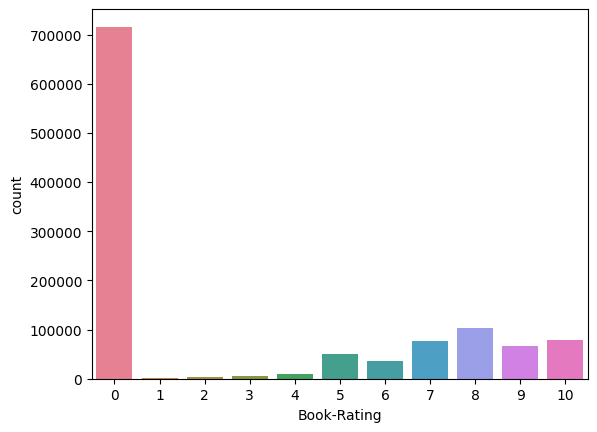

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns 

palette = sns.color_palette("husl", len(ratings['Book-Rating'].unique()))
sns.countplot(x=ratings['Book-Rating'], palette=palette, hue=ratings['Book-Rating'], legend=False)
plt.show() 

In [6]:
print(len(ratings['User-ID'].unique())) 
print(len(ratings['ISBN'].unique())) 

105283
340556


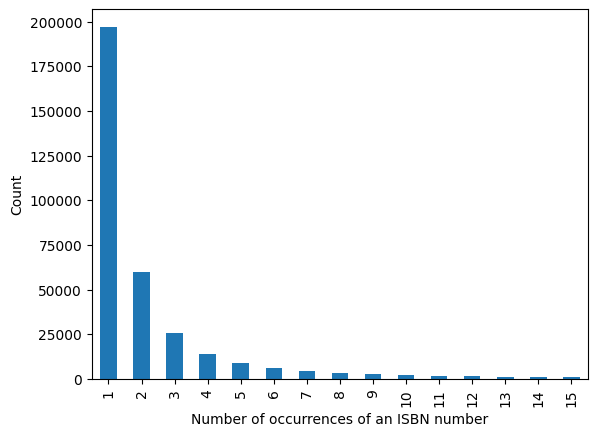

In [7]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")
plt.show()

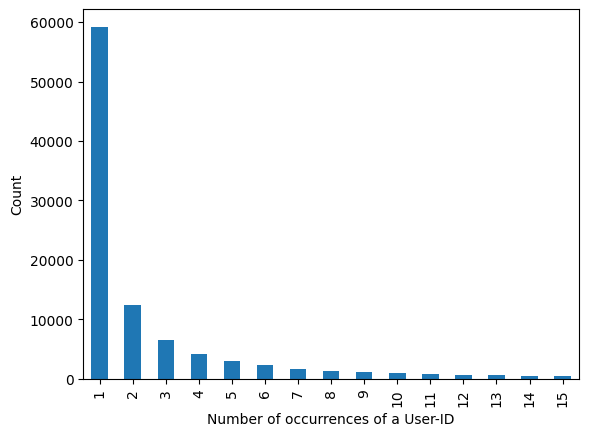

In [8]:
userid_counts = ratings.groupby('User-ID').size() 
count_occurrences = userid_counts.value_counts() 
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")
plt.show()

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [10]:
# Preprocessing
df = ratings.loc[ratings['ISBN'].isin(books['ISBN'].unique()) & ratings['User-ID'].isin(users['User-ID'].unique())]
# # Keep the 100k highest ratings
df = df[df['Book-Rating'] >= 8].iloc[:100000]

In [11]:
df.head()

,User-ID,ISBN,Book-Rating
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
27,276751,3596218098,8
28,276754,0684867621,8


In [12]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [13]:
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [14]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [15]:
def sample_mini_batch(edge_index, batch_size=128):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=batch_size)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

In [16]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [17]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items, LAMBDA=0.01):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [18]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [19]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [20]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [21]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [22]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [23]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 128

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

: 

In [25]:
%%time
from tqdm import tqdm

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in tqdm(range(2)):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index, batch_size=BATCH_SIZE)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items, LAMBDA)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

  0%|          | 0/2 [00:00<?, ?it/s]